In [1]:
import numpy as np
import my_statistics as stat
import scipy as sc
from datetime import datetime, timedelta
import pandas as pd

In [56]:
import scipy.interpolate as sci

In [2]:
import sys

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib nbagg

### Gathering and Plotting the data (for Parts 1 and 2)

In [5]:
all_hour = np.loadtxt("Data/AllStations_temperature_hour_data_2019.dat")

In [6]:
uvic_sci_hour_temp = np.zeros(len(all_hour) - 2)
uvic_sci_hour_time = np.zeros(len(all_hour) - 2)
for i in range(2, len(all_hour)):
    uvic_sci_hour_time[i-2] = all_hour[i][0]    
    uvic_sci_hour_temp[i-2] = all_hour[i][-3]

In [7]:
epoch = datetime(1, 1, 1)
uvic_sci_hour_time_pretty = [epoch + timedelta(days=y-367.0) for y in uvic_sci_hour_time]

In [61]:
hour_res_17_time = []
hour_res_17_temp = []
hour_res_18_time = []
hour_res_18_temp = []

print_once = 0
start_stop_indices = []
list_of_nans = []

for i in range(len(uvic_sci_hour_time)):
    time = uvic_sci_hour_time_pretty[i]
    if np.isnan(uvic_sci_hour_temp[i]):
        list_of_nans.append(i) 
    
    stop_when = time.year == 2018 and time.month == 9 and time.day == 2
     
    if time.year == 2017:
        if time.month == 10 and time.day >= 28:
            hour_res_17_time.append(time)
            hour_res_17_temp.append(uvic_sci_hour_temp[i])
            
        if time.month >= 11:
            hour_res_17_time.append(time)
            hour_res_17_temp.append(uvic_sci_hour_temp[i])
            
    if time.year == 2018:
        if time.month == 1 and time.day <= 26:
            hour_res_17_time.append(time)
            hour_res_17_temp.append(uvic_sci_hour_temp[i])        
            
        if time.month >= 6:
            hour_res_18_time.append(time)
            hour_res_18_temp.append(uvic_sci_hour_temp[i])  
    
    if time.year == 2017 and time.month == 10 and time.day == 28 and print_once == 0:
        print_once += 1
        start_stop_indices.append(i)
    if time.year == 2018 and time.month == 1 and time.day == 27 and print_once == 1:
        print_once += 1
        start_stop_indices.append(i)
    if time.year == 2018 and time.month == 6 and print_once == 2:
        print_once += 1
        start_stop_indices.append(i)
    if stop_when:
        start_stop_indices.append(i)
        print("Done")
        break

Done


In [68]:
np.array(list_of_nans)

array([    0,     1,     2, ..., 80594, 88313, 89330])

In [71]:
#fills in the NaN values for what we're working with, using linear interpolation - works mainly for discrete NaN values. 
filler_time = list(uvic_sci_hour_time)
filler_temp = list(uvic_sci_hour_temp)

for i in range(len(list_of_nans)):
    filler_time.pop(list_of_nans[i] - i)
    filler_temp.pop(list_of_nans[i] - i)

#This is because the first element is missing.
filler_time.append(uvic_sci_hour_time[0])
filler_temp.append(uvic_sci_hour_temp[0])

filler_fn = sci.interp1d(filler_time, filler_temp)

for i in list_of_nans:
    uvic_sci_hour_temp[i] = filler_fn(uvic_sci_hour_time[i])

In [27]:
hour_17_dict = {'Time':hour_res_17_time, 'Temperature': hour_res_17_temp}
hour_17_df = pd.DataFrame(hour_17_dict)
hour_18_dict = {'Time':hour_res_18_time, 'Temperature': hour_res_18_temp}
hour_18_df = pd.DataFrame(hour_18_dict)

<IPython.core.display.Javascript object>


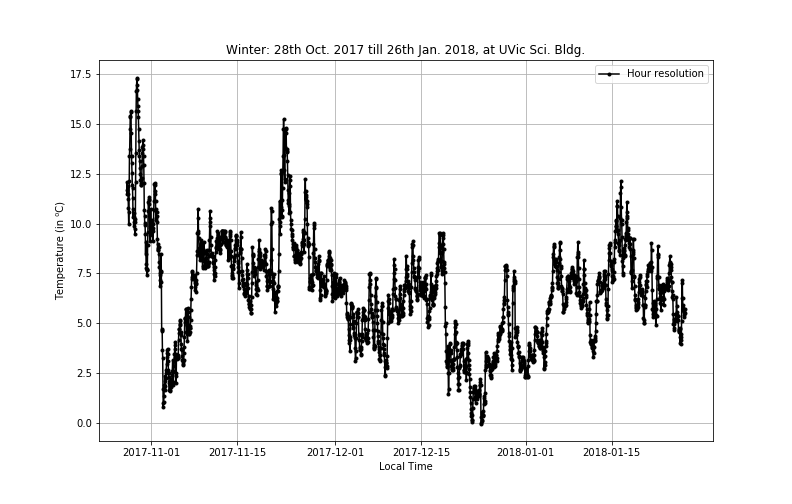

In [66]:
plt.figure(figsize=(11,7))
plt.plot(hour_res_17_time, hour_res_17_temp, 'k.-', label="Hour resolution")
plt.title("Winter: 28th Oct. 2017 till 26th Jan. 2018, at UVic Sci. Bldg.")
plt.xlabel("Local Time")
plt.ylabel("Temperature (in \u2070C)")
plt.grid(True)
plt.legend()

In [67]:
plt.close()

<IPython.core.display.Javascript object>


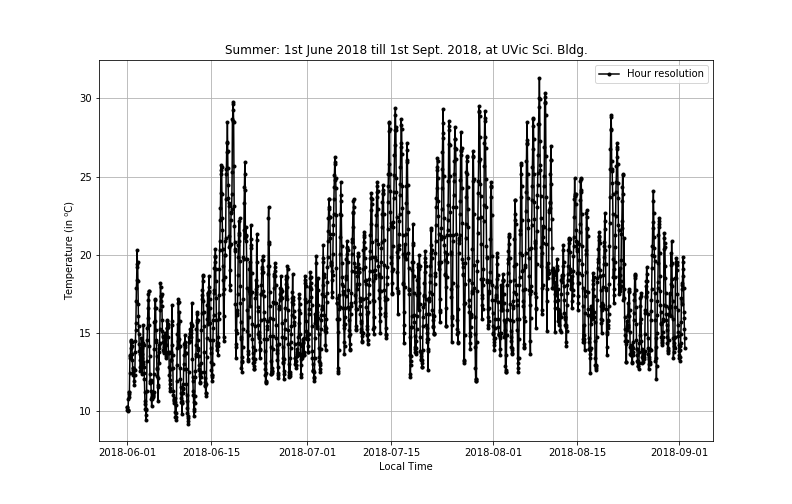

In [25]:
plt.figure(figsize=(11,7))
plt.plot(hour_res_18_time, hour_res_18_temp, 'k.-', label="Hour resolution")
plt.title("Summer: 1st June 2018 till 1st Sept. 2018, at UVic Sci. Bldg.")
plt.xlabel("Local Time")
plt.ylabel("Temperature (in \u2070C)")
plt.grid(True)
plt.legend()

In [26]:
plt.close()

### Part 1 - Winter Graph comparison

In [20]:
wint_mean = hour_17_df["Temperature"].mean()
wint_var = hour_17_df["Temperature"].var()

In [73]:
auto_correlation_winter = []
N_wint = start_stop_indices[1] - start_stop_indices[0]
for tau in range(41):
    add = sum([(uvic_sci_hour_temp[counter] - wint_mean)*(uvic_sci_hour_temp[counter + tau*24] - wint_mean) for counter in range(start_stop_indices[0], start_stop_indices[1])])
    #print(add)
    auto_correlation_winter.append(add/(N_wint - 1)/wint_var)

<IPython.core.display.Javascript object>


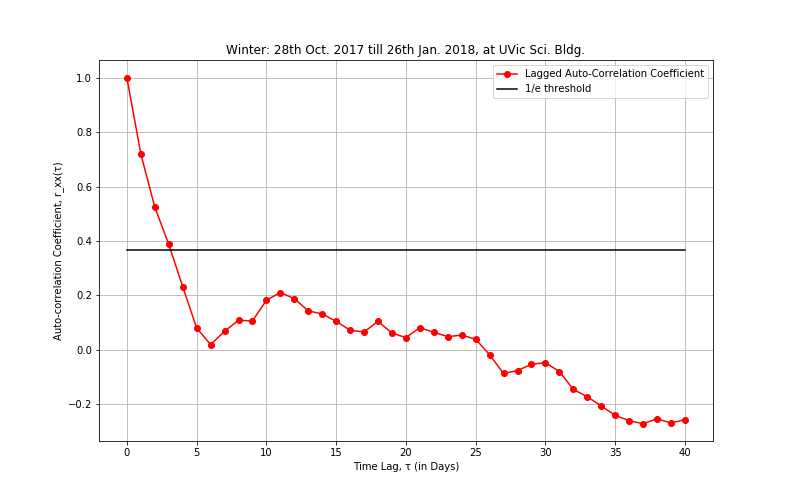

In [74]:
plt.figure(figsize=(11,7))
plt.plot(range(41), np.array(auto_correlation_winter), 'ro-', label="Lagged Auto-Correlation Coefficient")
plt.plot(range(41), np.ones(41)/np.e, 'k-', label="1/e threshold")
plt.title("Winter: 28th Oct. 2017 till 26th Jan. 2018, at UVic Sci. Bldg.")
plt.xlabel("Time Lag, \u03C4 (in Days)")
plt.ylabel("Auto-correlation Coefficient, r_xx(\u03C4)")
plt.grid(True)
plt.legend()

In [75]:
plt.close()

Decorrelation time scale = ~4 days

### Part 2 - Summer Graph comparison

In [76]:
summ_mean = hour_18_df["Temperature"].mean()
summ_var = hour_18_df["Temperature"].var()

In [77]:
auto_correlation_summer = []
N_summ = start_stop_indices[3] - start_stop_indices[2]
for tau in range(41):
    add = sum([(uvic_sci_hour_temp[counter] - summ_mean)*(uvic_sci_hour_temp[counter + tau*24] - summ_mean) for counter in range(start_stop_indices[2], start_stop_indices[3])])
    #print(add)
    auto_correlation_summer.append(add/(N_summ - 1)/summ_var)

<IPython.core.display.Javascript object>


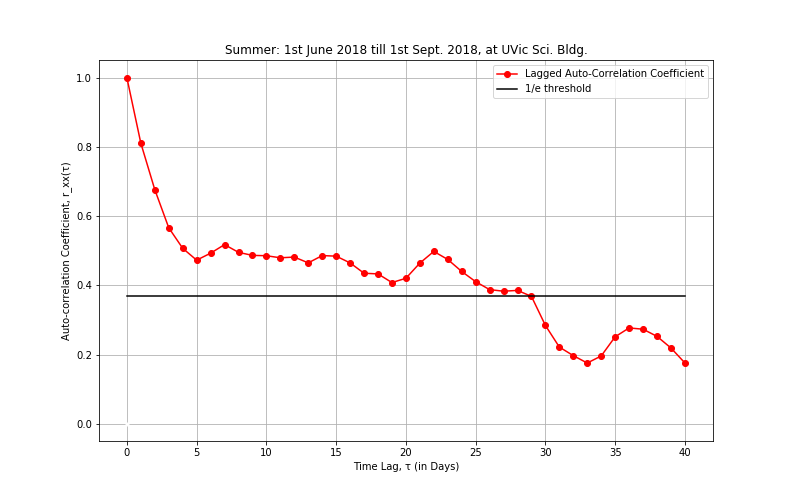

In [78]:
plt.figure(figsize=(11,7))
plt.plot(range(41), np.array(auto_correlation_summer), 'ro-', label="Lagged Auto-Correlation Coefficient")
plt.plot(range(41), np.ones(41)/np.e, 'k-', label="1/e threshold")
plt.plot(0, 0, 'w.')
plt.title("Summer: 1st June 2018 till 1st Sept. 2018, at UVic Sci. Bldg.")
plt.xlabel("Time Lag, \u03C4 (in Days)")
plt.ylabel("Auto-correlation Coefficient, r_xx(\u03C4)")
plt.grid(True)
plt.legend()

In [79]:
plt.close()

Decorrelation time scale <= 30 days

### Part 3 - Inference

As is evident from Part 1 and Part 2, the auto-correlation coefficient > 1/e for more days in Part 2 than in Part 1. Specificially, Decorrelation time scale for winter is MUCH smaller than Summer $\Rightarrow$ this dummy weather forecast is better at predicting Summer weather, than Winter weather, overall.

For individual offsets too (like, for example, $\tau$ = 1, i.e. predicting today's weather using yesterday's weather), r$_{xx}(\tau)_{Summer}$ > r$_{xx}(\tau)_{Winter}$ $\Rightarrow$ Summer predictions are better than Winter predictions, for dummy weather forecast.

This also implies that the Summer weather is more consistent, i.e. varies more slowly, than Winter weather, on a day-to-day basis.